In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Hyperparams
batch_size = 64
learing_rate = 1e-4
epochs = 20

# Load Data
- First using tf data to load data
- Difference here is that info does not contain sub class of anything
- When loading, there's no need to specify as_supervised argument, due to text data already return as such

In [3]:
(train_ds, valid_ds, test_ds), ds_info = tfds.load(
    'goemotions', split=['train', 'validation', 'test'], 
    with_info=True
)

In [56]:
index_label = dict([(index, item) for index, item in enumerate(list(ds_info.features)[1:])])
label_index = dict([(item, index) for index, item in enumerate(list(ds_info.features)[1:])])

# EDA
- Lets explore understand the data
  - Lets plot the class distribution
  - Lets plot the length of our text with a violin plot

- Lets convert to a dataframe so that we can visualize and explore the data better

NOTE: This is a multilabel classification problem

In [66]:
train_df = tfds.as_dataframe(train_ds, ds_info)
test_df = tfds.as_dataframe(test_ds, ds_info)
valid_df = tfds.as_dataframe(valid_ds, ds_info)

In [6]:
train_df['comment_length'] = train_df['comment_text'].apply(lambda x: len(x))

In [7]:
train_df.head()

,admiration,amusement,anger,annoyance,approval,caring,comment_text,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,neutral,optimism,pride,realization,relief,remorse,sadness,surprise,comment_length
0,False,False,False,False,False,False,"b""It's just wholesome content, from questionab...",False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,54
1,True,False,False,False,False,False,b'This is actually awesome.',False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,25
2,False,False,False,False,False,False,"b""People really spend more than $10 in an app ...",True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,116
3,False,False,False,False,False,False,b'I grew up on the other side of Ama but live ...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,93
4,False,False,False,False,False,False,"b'What the problem? I mean, steak? Good. Dough...",False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,81


In [67]:
def normalize_labels(df: pd.DataFrame):
  label_data = []
  for vals in df.itertuples(index=False):
    temp_label = ''
    for key, label in index_label.items():
      if vals[key]:
        if len(temp_label) > 0:
          temp_label += '|' +  label
        else:
          temp_label += label

    label_data.append(temp_label)

  df['label'] = label_data

In [71]:
normalize_labels(train_df)
normalize_labels(valid_df)
normalize_labels(test_df)

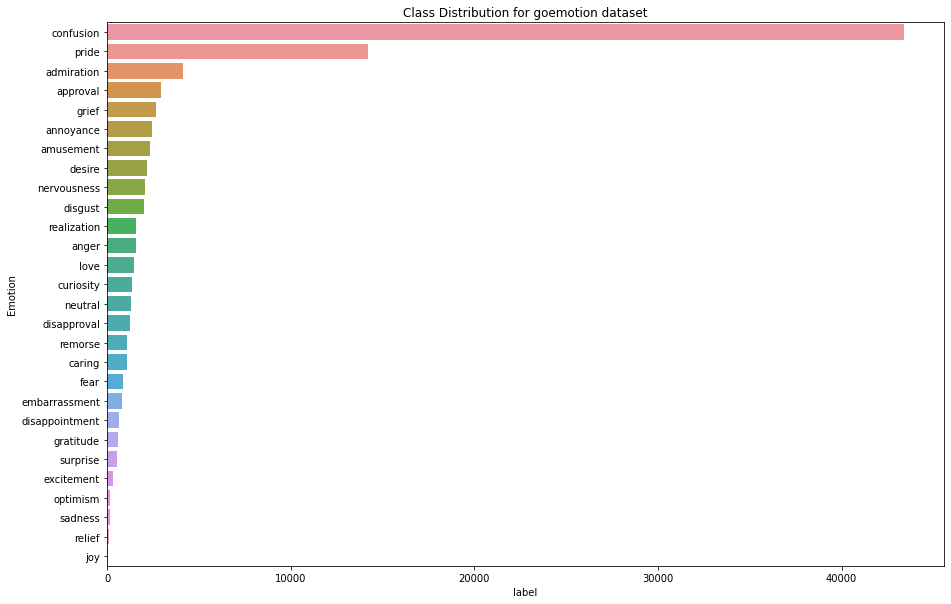

In [9]:
label_freq = train_df['label'].apply(lambda x: x.split('|')).explode().value_counts().sort_values(ascending=False)

plt.figure(figsize=(15, 10))
plt.title('Class Distribution for goemotion dataset')
plt.ylabel('Emotion')
sns.barplot(x=label_freq, y=label_freq.index.values)

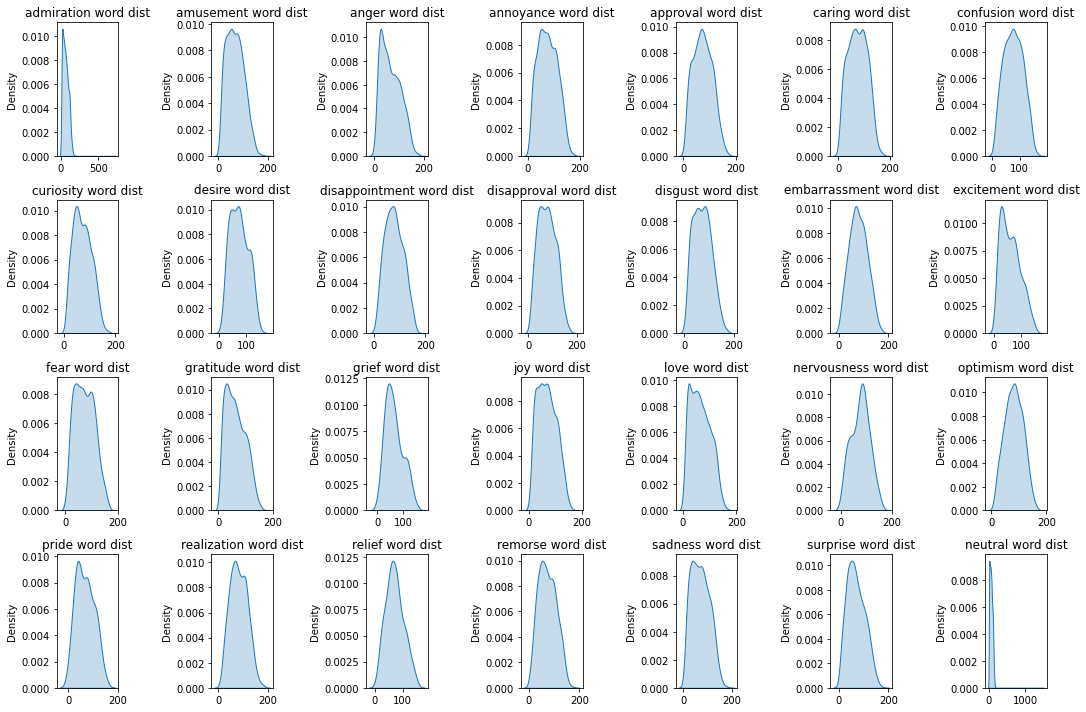

In [10]:
plt.figure(figsize=(15, 10))
for index, label in enumerate(index_label.values()):
  groups = train_df.loc[train_df[label] == True]['comment_length'].values
  plt.subplot(4, 7, index + 1)
  plt.title(label + ' word dist')
  # plt.plot(groups)
  sns.kdeplot(x=groups, fill=True)

plt.tight_layout()

In [11]:
# Lets visualize and get a few samples
for val in train_df.sample(10).itertuples(index=False):
  labels = val.label.split('|')
  print(val.comment_text.decode("utf-8") + ' , labels:' + str(labels))

Crochet, my good friend , labels:['confusion', 'pride']
Yeah....each state gets two senators regardless of population. None are favored. Population is represented in the House. , labels:['confusion', 'disgust']
Holy hell I hate them so much. , labels:['anger', 'annoyance', 'confusion']
It's a beautiful video of family and [NAME] finally accepting [NAME] as a brother is one of the highlights of the show , labels:['admiration', 'confusion']
Awesome!! Also, I have those same markers! , labels:['admiration', 'confusion']
I can't wait for mom to slap his hand down , labels:['confusion', 'fear']
Big game tonight , labels:['confusion', 'pride']
Sorry, mom took it out of the oven already and I am STARVING! , labels:['caring', 'confusion']
I’m on mobile and I can see them. Omg it makes me so happy 😂 never noticed if before either. iPhone btw , labels:['approval', 'confusion', 'love', 'remorse']
Just stop. , labels:['anger', 'confusion']


# Lets learn to map data
- We have to convert our data to one hot encoding of all classes
- We need to remove any sort of unnecessary symbol within our dataset

NOTE: After various attempts the best version seems to be converting from a dataframe parsing the individual labels to become a format i wanted for binary crossentropy

-> text, [1, 0 1, 0, 0]

In [30]:
def multi_label_oh_encoding(labels, num_classes):
  return tf.reduce_max(tf.one_hot(labels, num_classes), axis=0)

In [58]:
def norm_data(data):
  comment_text = data['comment_text'].values
  total_labels = []
  for d in data['label'].values:
    labels = [label_index[label] for label in d.split('|')]
    total_labels.append(multi_label_oh_encoding(labels, 28))
  return comment_text, total_labels

In [63]:
def normalize_dataset(dataset: pd.DataFrame):
  total_comment, total_labels = norm_data(dataset)
  return tf.data.Dataset.from_tensor_slices((total_comment, total_labels))

In [72]:
norm_train_ds = normalize_dataset(train_df)
norm_valid_ds = normalize_dataset(valid_df)
norm_test_ds = normalize_dataset(test_df)

In [73]:
norm_train_ds = norm_train_ds.shuffle(1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
norm_test_ds = norm_test_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
norm_valid_ds = norm_valid_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [75]:
for text, labels in norm_train_ds.take(1):
  for i in range(10):
    print('Text: {} , Label: {}'.format(text[i], labels[i]))

Text: b'There was nothing innovating lol. It was good but chill' , Label: [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Text: b'They hated him, because he told them the truth' , Label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1.]
Text: b">We had a bunch in the prequels (which also suck, please stop giving them too much credit salt miners). It's treason then. " , Label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0.]
Text: b"Instant karma for an impatient jackass who doesn't deserve the right to drive." , Label: [0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Text: b'Nope, don\xe2\x80\x99t even know what dart is. Sorry. And thanks!' , Label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Text: b"All. I too, am drunk, and will be enjoying half price burgers at Whitlow's once my appetite kic

# Model Building
- We will use a simple sequential model
- We will use the text vectorization layer
- Our final layer will be sigmoid
- We will use a binary cross entropy loss

In [123]:
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=1000, pad_to_max_tokens=True
)
encoder.adapt(norm_train_ds.map(lambda text, label: text))

In [124]:
encoder.get_vocabulary()[:50]

['',
 '[UNK]',
 'the',
 'i',
 'to',
 'a',
 'you',
 'and',
 'is',
 'that',
 'name',
 'it',
 'of',
 'this',
 'in',
 'for',
 'was',
 'my',
 'not',
 'but',
 'be',
 'on',
 'so',
 'just',
 'have',
 'are',
 'like',
 'with',
 'me',
 'they',
 'your',
 'he',
 'what',
 'its',
 'if',
 'as',
 'im',
 'at',
 'all',
 'about',
 'no',
 'do',
 'love',
 'one',
 'get',
 'people',
 'we',
 'would',
 'good',
 'dont']

In [125]:
np.array(encoder.get_vocabulary())[encoder(['This is content']).numpy()[0]]

array(['this', 'is', '[UNK]'], dtype='<U15')

In [135]:
# Finall time to build a model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1,), dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.5)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(28, activation='sigmoid')
])

In [136]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_3 (TextVe (None, None)              0         
_________________________________________________________________
embedding_11 (Embedding)     (None, None, 64)          64000     
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 128)               66048     
_________________________________________________________________
dense_24 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 28)                3612      
Total params: 150,172
Trainable params: 150,172
Non-trainable params: 0
_______________________________________________

In [166]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learing_rate),
    metrics=['accuracy']
)

In [167]:
history = model.fit(
    norm_train_ds, validation_data=norm_valid_ds, epochs=2
)

Epoch 1/2
679/679 [==============================] - 9s 10ms/step - loss: 0.1492 - binary_accuracy: 0.9585 - val_loss: 0.1417 - val_binary_accuracy: 0.9589
Epoch 2/2
679/679 [==============================] - 6s 9ms/step - loss: 0.1435 - binary_accuracy: 0.9592 - val_loss: 0.1375 - val_binary_accuracy: 0.9599


In [130]:
model.evaluate(norm_test_ds)

85/85 [==============================] - 0s 5ms/step - loss: 0.1434 - accuracy: 0.6921


[0.1433870643377304, 0.6920951008796692]

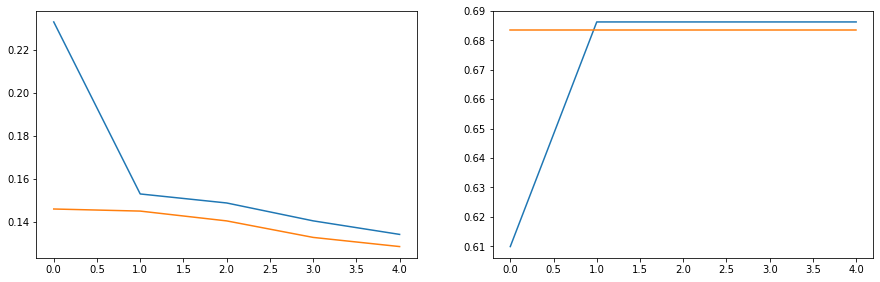

In [113]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.subplot(222)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Lets predict manually

In [176]:
text_sample = test_df.sample(2)
predictions = model.predict(text_sample['comment_text'])

In [177]:
preds = predictions > 0.5

In [178]:
for i, pred in enumerate(preds):
  labels = []
  for index, p in enumerate(pred):
    if p:
      labels.append(index_label[index])

  print(text_sample.iloc[i]['comment_text'], labels, text_sample.iloc[i]['label'])

b'"How did they get away from everyone. "Fillies and gentlecolts,we are gathered here today to honor the nation of England for this Oscar.' ['confusion', 'pride'] confusion|pride
b"At least he's finally done one thing right. Utter fucking disappointment at every level, by every metric." ['confusion'] confusion|disapproval
